In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from math import sqrt
import warnings

from scipy.stats import norm
from sklearn.decomposition import PCA

In [3]:
# Ignore runtime warning
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Wine data

In [4]:
df_wine = pd.read_csv('data/wine.data', on_bad_lines='skip', sep=',')

In [5]:
headers_wine = ['title', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
           'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
           'OD280', 'Proline']
df_wine.columns = headers_wine

In [6]:
selected_columns_wine = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
           'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
           'OD280', 'Proline']

# Iris data

In [7]:
df_iris = pd.read_csv('data/iris.data', on_bad_lines='skip', sep=',')

In [8]:
headers_iris = ['sep_len', 'sep_wid', 'pet_len', 'pet_len', 'class']
df_iris.columns = headers_iris

In [9]:
selected_columns_iris = ['sep_len', 'sep_wid', 'pet_len', 'pet_len']

In [10]:
df_iris = df_iris.replace("Iris-setosa", 1)
df_iris = df_iris.replace("Iris-versicolour", 2)
df_iris = df_iris.replace("Iris-virginica", 3)

# Landsat data

In [11]:
df_landsat = pd.read_csv('data/landsat.tst', on_bad_lines='skip', sep=' ')

In [12]:
headers_landsat = [i for i in range(37)]
df_landsat.columns = headers_landsat

In [13]:
selected_columns_landsat = headers_landsat[:36]

# Magic data

In [14]:
df_magic = pd.read_csv('data/magic.data', on_bad_lines='skip', sep=',')

In [15]:
headers_magic = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
                 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df_magic.columns = headers_magic

In [16]:
selected_columns_magic = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
                 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

# Glass data

In [17]:
df_glass = pd.read_csv('data/glass.data', on_bad_lines='skip', sep=',')

In [18]:
headers_glass = ['id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'class']
df_glass.columns = headers_glass

In [19]:
selected_columns_glass = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

# Standart scaler

In [20]:
X_wine = df_wine[selected_columns_wine]
X_iris = df_iris[selected_columns_iris]
X_landsat = df_landsat[selected_columns_landsat]
X_magic = df_magic[selected_columns_magic]
X_glass = df_glass[selected_columns_glass]

In [21]:
scaler = StandardScaler()

In [22]:
X_wine = scaler.fit_transform(X_wine)
X_iris = scaler.fit_transform(X_iris)
X_landsat = scaler.fit_transform(X_landsat)
X_magic = scaler.fit_transform(X_magic)
X_glass = scaler.fit_transform(X_glass)

# **HSE "Sequence-based analysis of iterative anomalous clusters"**

In [23]:
def dist(p1, p2):
    return sum((p1[i] - p2[i])**2 for i in range(len(p1)))

def farthest_point(df):
    origin = [0] * (df.shape[1])
    dists = []
    for i in range(df.shape[0]):
        dists.append([list(df.iloc[i]), dist(list(df.iloc[i]), origin)])
    dists.sort(key=lambda x: x[1], reverse=True)
    return dists[0][0]

def anom_clust(df, origin):
    if origin == '0':
        origin = [0] * (df.shape[1])
    else:
        origin = list(df.mean())
    c = farthest_point(df)
    cluster = pd.Series(index=range(df.shape[0]))
    while True:
        for i in range(len(df)):
            currpoint = list(df.iloc[i])
            if dist(currpoint, c) < dist(currpoint, origin):
                cluster[i] = 1
        cnew = []
        for i in df.columns:
            cnew.append(df.loc[(cluster == 1).values][i].mean())
        if c == cnew:
            break
        c = cnew
        cluster = pd.Series(index=range(df.shape[0]))
    return cluster, c

def BatchK_Means(df, centers):
    clusters = pd.Series(index=range(df.shape[0]))
    while True:
        for i in range(len(df)):
            currentity = list(df.iloc[i])
            dists = []
            for j in range(len(centers)):  
                dists.append([j, dist(currentity, centers[j])])
            dists.sort(key=lambda x: x[1])
            clusters[i] = dists[0][0]
        cnew = [0] * len(centers)
        for i in range(len(cnew)):
            newcenter = []
            for j in df.columns:
                newcenter.append(df.loc[(clusters == i).values][j].mean())
            cnew[i] = newcenter
        if centers == cnew:
            break
        centers = cnew
        clusters = pd.Series(index=range(df.shape[0]))
    return clusters, centers
    

def IK_Means(df, origin):
    I = df
    t = 1
    k = 1
    anom_clusters = []
    centers = []
    while not I.empty:
        S, c = anom_clust(I, origin)
        I = pd.concat([I, I.iloc[(S == 1).values]]).drop_duplicates(keep=False)
        k += 1
#         print(sum(S), c)
        if S.sum() > t:
            anom_clusters.append([S, c])
    anom_clusters.sort(key=lambda x: x[0].sum(), reverse=True)
    centers = [anom_clusters[0][1]]
    for i in range(1, len(anom_clusters)):
        if anom_clusters[i][0].sum() > anom_clusters[i - 1][0].sum() * 0.6:
            centers.append(anom_clusters[i][1])
    return BatchK_Means(df, centers)

def anom_res(X, name):
    anomwine, anomwinecent = IK_Means(X, "0")
    return f"Optimal number of clusters for {name} is: {len(pd.unique(anomwine))}"

In [24]:
X_wine_df = pd.DataFrame(X_wine)
X_iris_df = pd.DataFrame(X_iris)
X_landsat_df = pd.DataFrame(X_landsat)
X_magic_df = pd.DataFrame(X_magic)
X_glass_df = pd.DataFrame(X_glass)

print(anom_res(X_wine_df, 'wine'))
print(anom_res(X_iris_df, 'iris'))
print(anom_res(X_landsat_df, 'landsat'))
print(anom_res(X_magic_df, 'magic'))
print(anom_res(X_glass_df, 'glass'))

Optimal number of clusters for wine is: 7
Optimal number of clusters for iris is: 3
Optimal number of clusters for landsat is: 14
Optimal number of clusters for magic is: 6
Optimal number of clusters for glass is: 8


# Determine Cluster Number Without Clustering for Every K Based on Ratio of Variance to Range in K-Means

In [25]:
def clustering_with_dwr(Y):
    # Compute the maximum number of clusters for KMeans
    max_clusters = int(sqrt(Y.shape[0] / 2))
    
    distortions = [] # Store distortions for each different number of clusters
    for i in range(1, max_clusters + 1):
        # Apply KMeans with different numbers of clusters
        kmeans = KMeans(n_clusters=i, n_init=10).fit(Y)
        # Append distortions (inertia_)
        distortions.append(kmeans.inertia_)
    
    # Find the optimal number of clusters using the "elbow point" of the distortion graph
    K_star = find_elbow_point(np.array(distortions))
    
    # Apply the clustering algorithm again with the optimal number of clusters
    kmeans = KMeans(n_clusters=K_star, n_init=10).fit(Y)
    C_star = kmeans.labels_
    
    return K_star, C_star

def find_elbow_point(G):
    # This function finds the point of maximum curvature from the line defined by the first and last points.
    n_points = len(G)
    coords = np.vstack((range(n_points), G)).T
    first_point = coords[0]
    line = np.subtract(coords[-1], first_point)
    line_norm = line / np.sqrt(np.sum(line**2))
    vec_from_first = np.subtract(coords, first_point)
    scalar_product = np.sum(vec_from_first * np.tile(line_norm, (n_points, 1)), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_norm)
    vector_to_line = np.subtract(vec_from_first, vec_from_first_parallel)
    dist_to_line = np.sqrt(np.sum(vector_to_line ** 2, axis=1))
    idx_of_elbow = np.argmax(dist_to_line)
    return idx_of_elbow + 1

In [26]:
K_star, C_star = clustering_with_dwr(X_wine)
print("Optimal number of clusters wine:", K_star)

K_star, C_star = clustering_with_dwr(X_iris)
print("Optimal number of clusters iris:", K_star)

K_star, C_star = clustering_with_dwr(X_landsat)
print("Optimal number of clusters landsat:", K_star)

K_star, C_star = clustering_with_dwr(X_magic)
print("Optimal number of clusters magic:", K_star)

K_star, C_star = clustering_with_dwr(X_glass)
print("Optimal number of clusters glass:", K_star)

Optimal number of clusters wine: 3
Optimal number of clusters iris: 2
Optimal number of clusters landsat: 6
Optimal number of clusters magic: 14
Optimal number of clusters glass: 4


# Gausian Likelyhood Score Method


In [27]:
def gaussian_likelihood_score(points, labels, resolution=50, pca=True):
    probability = 0
    n_clusters = len(np.unique(labels))
    for j in range(n_clusters):
        cluster_points = points[labels == j]
        if pca:
            cluster_points = PCA(1).fit_transform(cluster_points)
            centroid = np.mean(cluster_points)
            spread = np.std(cluster_points)

            rv = norm(loc=centroid, scale=spread)
            hist, bins = np.histogram(cluster_points[:, 0], bins=resolution)
            probability_pca = np.sum(rv.logpdf(bins[:-1]) * hist)
            if np.isnan(probability_pca):
                probability_pca = 0.
            probability += probability_pca
        else:
            centroid = np.mean(cluster_points, axis=0)
            spread = np.std(cluster_points, axis=0)

            rv_1 = norm(loc=centroid[0], scale=spread[0])
            rv_2 = norm(loc=centroid[1], scale=spread[1])

            hist_1, bins_1 = np.histogram(
                cluster_points[:, 0], bins=resolution)
            hist_2, bins_2 = np.histogram(
                cluster_points[:, 1], bins=resolution)

            probability_axis_1 = np.sum(rv_1.logpdf(bins_1[:-1]) * hist_1)
            if np.isnan(probability_axis_1):
                probability_axis_1 = 0.
            probability_axis_2 = np.sum(rv_2.logpdf(bins_2[:-1]) * hist_2)
            if np.isnan(probability_axis_2):
                probability_axis_2 = 0.
            probability += probability_axis_1 + probability_axis_2
    return probability


def find_best_cluster(scores):
    scores = np.array(scores)
    # derivative of score
    d = scores - np.hstack([[0], scores[:-1]])
    dd = d[1:] / (d[:-1] + 1e-10)
    if dd[0] < 0:
        dd[0] = np.inf
    optimal_number = np.argmin(dd)
    return optimal_number

In [28]:
data_wine = df_wine[selected_columns_wine].values
data_iris = df_iris[selected_columns_iris].values
data_landsat = df_landsat[selected_columns_landsat].values
data_magic = df_magic[selected_columns_magic].values
data_glass = df_glass[selected_columns_glass].values

min_clusters = 2
max_clusters = 10

def gls_scores_calc(data):
    gls_scores = []
    for i in range(min_clusters, max_clusters + 1):

        clusterer = AgglomerativeClustering(n_clusters=i).fit(data)
        labels = clusterer.labels_
        
        score = gaussian_likelihood_score(data, labels)
        gls_scores.append(score)
    
    return gls_scores

optimal_clusters = find_best_cluster(gls_scores_calc(data_wine)) + min_clusters
print(f'The optimal number of clusters wine: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_iris)) + min_clusters
print(f'The optimal number of clusters iris: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_landsat)) + min_clusters
print(f'The optimal number of clusters landsat: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_magic)) + min_clusters
print(f'The optimal number of clusters magic: {optimal_clusters}')

optimal_clusters = find_best_cluster(gls_scores_calc(data_glass)) + min_clusters
print(f'The optimal number of clusters glass: {optimal_clusters}')

The optimal number of clusters wine: 3
The optimal number of clusters iris: 9
The optimal number of clusters landsat: 3
The optimal number of clusters magic: 3
The optimal number of clusters glass: 5


# Agglomerative clustering method

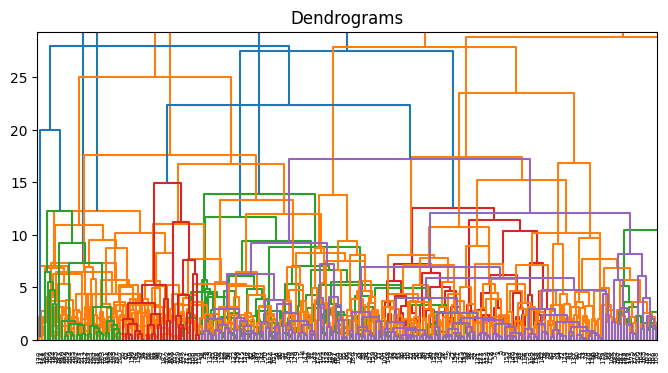

In [29]:
plt.figure(figsize= (8, 4))
plt.title("Dendrograms")
dend_wine = shc.dendrogram(shc.linkage (X_wine, method='ward'))
dend_iris = shc.dendrogram(shc.linkage (X_iris, method='ward'))
dend_landsat = shc.dendrogram(shc.linkage (X_landsat, method='ward'))
dend_magic = shc.dendrogram(shc.linkage (X_magic, method='ward'))
dend_glass = shc.dendrogram(shc.linkage (X_glass, method='ward'))

In [30]:
unique_colors_wine = set(dend_wine['color_list'])
unique_colors_iris = set(dend_iris['color_list'])
unique_colors_landsat = set(dend_landsat['color_list'])
unique_colors_magic = set(dend_magic['color_list'])
unique_colors_glass = set(dend_glass['color_list'])

In [31]:
optimal_number_of_clusters = len(unique_colors_wine) - 1
print(f'The optimal number of clusters wine: {optimal_number_of_clusters}')

optimal_number_of_clusters = len(unique_colors_iris) - 1
print(f'The optimal number of clusters iris: {optimal_number_of_clusters}')

optimal_number_of_clusters = len(unique_colors_landsat) - 1
print(f'The optimal number of clusters landsat: {optimal_number_of_clusters}')

optimal_number_of_clusters = len(unique_colors_magic) - 1
print(f'The optimal number of clusters magic: {optimal_number_of_clusters}')

optimal_number_of_clusters = len(unique_colors_glass) - 1
print(f'The optimal number of clusters glass: {optimal_number_of_clusters}')

The optimal number of clusters wine: 3
The optimal number of clusters iris: 2
The optimal number of clusters landsat: 3
The optimal number of clusters magic: 2
The optimal number of clusters glass: 4


# Elbow auto

In [32]:
def elbow_second_derivative(X, K_max=10):
    inertias = []
    for k in range(1, K_max+2):
        kmeans = KMeans(n_clusters=k, n_init=10).fit(X)
        inertias.append(kmeans.inertia_)

    second_derivative = [0] * (K_max - 1)
    for i in range(1, K_max):
        second_derivative[i-1] = inertias[i+1] + inertias[i-1] - 2 * inertias[i]

    optimal_k = np.argmax(second_derivative) + 2
    return optimal_k


In [33]:
print('The optimal number of clusters wine:',elbow_second_derivative(X_wine))

print('The optimal number of clusters iris:',elbow_second_derivative(X_iris))

print('The optimal number of clusters landsat:',elbow_second_derivative(X_landsat))

print('The optimal number of clusters magic:',elbow_second_derivative(X_magic))

print('The optimal number of clusters glass:',elbow_second_derivative(X_glass))

The optimal number of clusters wine: 3
The optimal number of clusters iris: 2
The optimal number of clusters landsat: 3
The optimal number of clusters magic: 2
The optimal number of clusters glass: 3


# Elbow

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow_method(X, dataset_name):
    inertia = []
    clusters = range(1, 11)

    for n in clusters:
        kmeans = KMeans(n_clusters=n, random_state=1, n_init=10).fit(X)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(6, 6))
    plt.plot(clusters, inertia, '-o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method for {dataset_name}')
    plt.grid(True)
    plt.show()


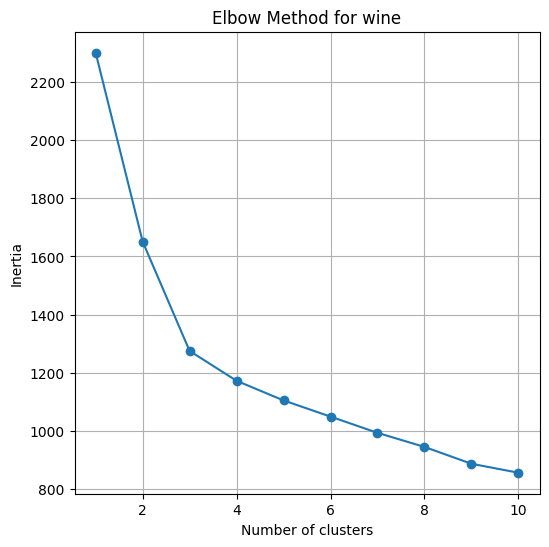

The optimal number of clusters wine: 


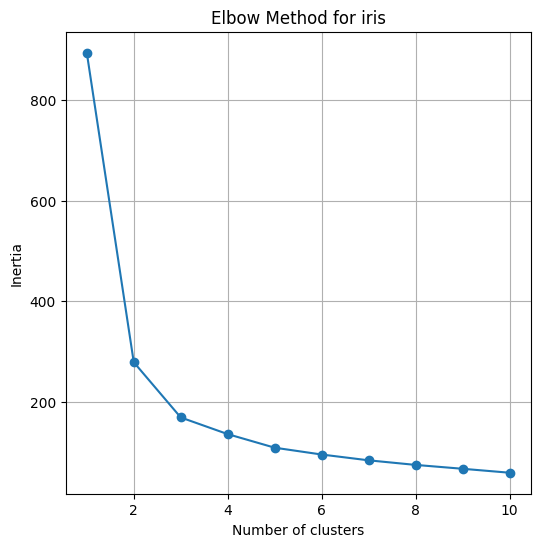

The optimal number of clusters iris: 


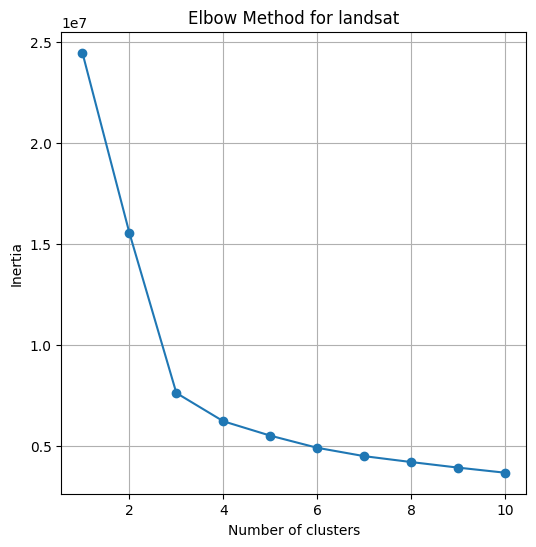

The optimal number of clusters landsat: 


In [35]:
elbow_method(X_wine, 'wine')
print("The optimal number of clusters wine: ")

elbow_method(X_iris, 'iris')
print("The optimal number of clusters iris: ")

elbow_method(data_landsat, 'landsat')
print("The optimal number of clusters landsat: ")

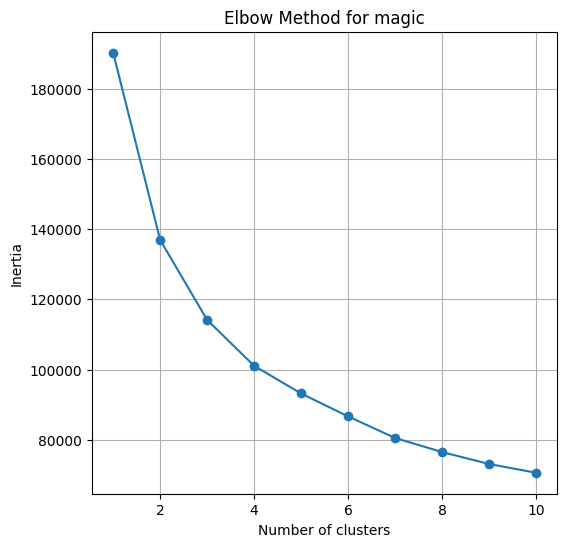

The optimal number of clusters magic: 


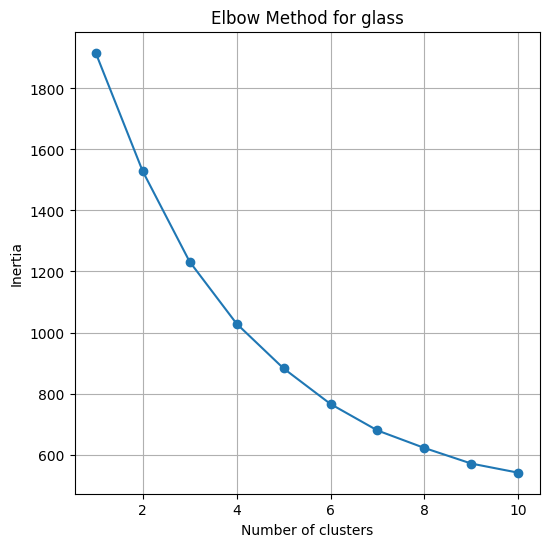

The optimal number of clusters glass: 


In [36]:
elbow_method(X_magic, 'magic')
print("The optimal number of clusters magic: ")

elbow_method(X_glass, 'glass')
print("The optimal number of clusters glass: ")

# DeD Method

In [41]:
def depth(point, data):
    return np.mean(np.linalg.norm(data - point, axis=1))

def data_depth(X, k_range=None, n_init=50):
    # Normalize the data
    X = StandardScaler().fit_transform(X)

    # Set default k_range based on the size of the dataset
    if k_range is None:
        k_range = (2, int(np.sqrt(X.shape[0] / 2)))
    
    n = len(X)
    depths = np.array([depth(x, X) for x in X])
    median_depth = np.median(depths)
    A = np.mean(np.abs(depths - median_depth))

    DeD_scores = []

    for k in range(*k_range):
        clusterer = KMeans(n_clusters=k, n_init=n_init).fit(X)
        labels = clusterer.labels_
        cluster_As = []
        for i in range(k):
            cluster_points = X[labels == i]
            cluster_depths = np.array([depth(x, cluster_points) for x in cluster_points])
            cluster_median_depth = np.median(cluster_depths)
            cluster_As.append(np.mean(np.abs(cluster_depths - cluster_median_depth)))
        DW = np.mean(cluster_As)
        DB = A - DW

        # Change the evaluation to division instead of subtraction
        # Add a small constant in the denominator to avoid division by zero
        DeD = DW - DB
        DeD_scores.append(DeD)

    optimal_clusters = np.argmax(DeD_scores) + k_range[0]

    return optimal_clusters

In [ ]:
optimal_clusters = data_depth(X_wine)
print(f"The optimal number of clusters wine {optimal_clusters}")

optimal_clusters = data_depth(X_iris)
print(f"The optimal number of clusters iris {optimal_clusters}")

optimal_clusters = data_depth(X_landsat)
print(f"The optimal number of clusters landsat {optimal_clusters}")

optimal_clusters = data_depth(X_magic)
print(f"The optimal number of clusters magic {optimal_clusters}")

optimal_clusters = data_depth(X_glass)
print(f"The optimal number of clusters glass {optimal_clusters}")